In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('Gold Price (2013-2023).csv')

def convert_volume(vol):
    if pd.isna(vol) or vol == '':
        return np.nan
    vol = vol.replace(',', '')
    if vol.endswith('K'):
        return float(vol[:-1]) * 1_000
    if vol.endswith('M'):
        return float(vol[:-1]) * 1_000_000
    return float(vol)

def preprocess_data(df):
    df = df.copy()

    # Date
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.set_index('Date', inplace=True)

    # Convert numeric columns (except Vol., Change %)
    price_cols = ['Price', 'Open', 'High', 'Low']
    for col in price_cols:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(',', '')
            .astype(float)
        )
    
    df['Vol.'] = df['Vol.'].apply(convert_volume)

    df = df.asfreq('B')

    # Target
    df['Target'] = df['Price'].shift(-1)

    # Handle missing values
    df.replace(0, np.nan, inplace=True)
    df = df.interpolate(method='time').ffill().bfill()

    return df

target = 'Target'
df = preprocess_data(df)
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

def get_metrics(true, pred, name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred) * 100
    r2 = r2_score(true, pred)

    true_diff = np.sign(np.array(true)[1:] - np.array(true)[:-1])
    pred_diff = np.sign(np.array(pred)[1:] - np.array(pred)[:-1])
    directional_acc = np.mean(true_diff == pred_diff) * 100 if len(true_diff) > 0 else np.nan
    print(f"[{name}] RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R2: {r2:.4f}, Directional Accuracy: {directional_acc:.2f}%")
    return [rmse, mape, r2, directional_acc]

print(f"Pipeline ready. Train: {len(train)}, Test: {len(test)}")

Pipeline ready. Train: 2347, Test: 261


C:\Users\hoang\AppData\Local\Temp\ipykernel_10632\2854970037.py:47: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='time').ffill().bfill()


In [2]:
def get_features(history_df):
    """Calculates features for the most recent point in the provided history."""
    recent = history_df.tail(60).copy()
    
    # Indicators
    ma10 = recent['Price'].rolling(window=10).mean().iloc[-1]
    ma50 = recent['Price'].rolling(window=50).mean().iloc[-1]
    
    # RSI calculation
    delta = recent['Price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean().iloc[-1]
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean().iloc[-1]
    rsi = 100 - (100 / (1 + (gain/loss))) if loss != 0 else 50
    
    last = recent.iloc[-1]
    return np.array([last['Open'], last['High'], last['Low'], last['Vol.'], ma10, ma50, rsi]).reshape(1, -1)

# Base features for initial training
def prepare_static_features(data_df):
    temp = data_df.copy()
    temp['MA10'] = temp['Price'].rolling(10).mean()
    temp['MA50'] = temp['Price'].rolling(50).mean()
    delta = temp['Price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    temp['RSI'] = 100 - (100 / (1 + (gain/loss)))
    temp = temp.dropna()
    features = ['Open', 'High', 'Low', 'Vol.', 'MA10', 'MA50', 'RSI']
    return temp[features], temp[target]

X_static, y_static = prepare_static_features(train)

XGBoost

Searching for optimized XGBoost parameters...
Best Parameters Found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Running Recursive Walk-Forward for XGBoost...
[XGBoost] RMSE: 24.52, MAPE: 1.08%, R2: 0.9280, Directional Accuracy: 48.46%


Text(0.5, 1.0, 'XGBoost')

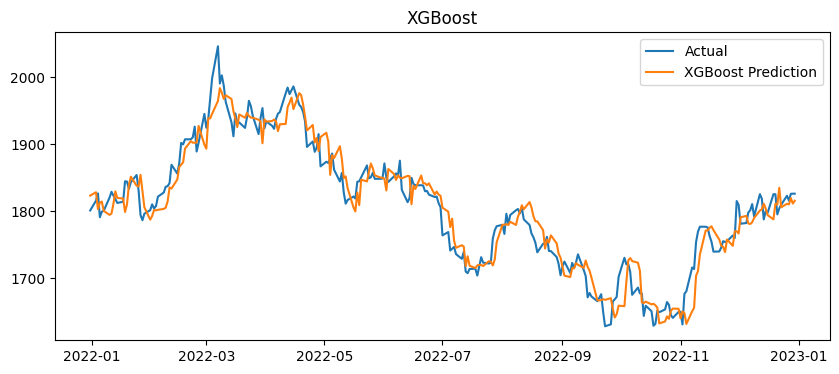

In [3]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=3)
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42)

print("Searching for optimized XGBoost parameters...")
grid_search = GridSearchCV(
    estimator=xgb_base, 
    param_grid=param_grid, 
    cv=tscv, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

# 3. INITIAL TRAINING
# Fit the search using the static features prepared from the 90% training data
grid_search.fit(X_static, y_static)
best_xgb_model = grid_search.best_estimator_
print(f"Best Parameters Found: {grid_search.best_params_}")

# 4. RECURSIVE WALK-FORWARD PREDICTION
# This loop recalculates features every day using only past information
xgb_preds = []
history = train.copy()

print("Running Recursive Walk-Forward for XGBoost...")
for i in range(len(test)):
    # Calculate features for 'today' based on history
    X_curr = get_features(history)
    
    # Predict tomorrow's price
    xgb_preds.append(best_xgb_model.predict(X_curr)[0])
    
    # Update history with the actual row from the test set for next day's feature calculation
    actual_row = test.iloc[[i]]
    history = pd.concat([history, actual_row])

xgb_res = get_metrics(test[target], xgb_preds, "XGBoost")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target], label='Actual')
plt.plot(test.index, xgb_preds, label='XGBoost Prediction')
plt.legend()
plt.title("XGBoost")

d:\Project 1\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Project 1\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Project 1\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Project 1\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Project 1\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to

[ARIMA] RMSE: 17.49, MAPE: 0.72%, R2: 0.9634, Directional Accuracy: 46.15%


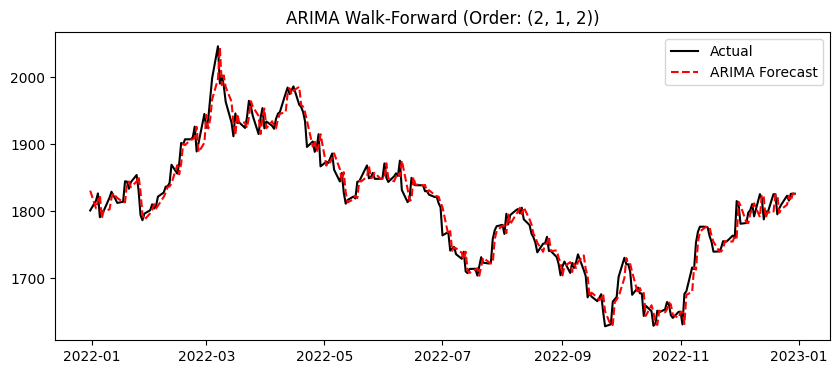

In [ ]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

# Find best parameters
arima_search = pm.auto_arima(train[target], seasonal=False, stepwise=True, suppress_warnings=True)
best_order = arima_search.order

arima_history = list(train[target])
arima_preds = []

for t in range(len(test)):
    model_fit = ARIMA(arima_history, order=best_order).fit()
    arima_preds.append(model_fit.forecast()[0])
    arima_history.append(test[target].iloc[t])

arima_res = get_metrics(test[target], arima_preds, "ARIMA")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target], label='Actual', color='black')
plt.plot(test.index, arima_preds, label='ARIMA Forecast', color='red', linestyle='--')
plt.title(f"ARIMA Walk-Forward (Order: {best_order})")
plt.legend()
plt.show()

d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation

[Linear Regression] RMSE: 23.49, MAPE: 1.02%, R2: 0.9339, Directional Accuracy: 47.31%


d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation

Text(0.5, 1.0, 'Linear Regression')

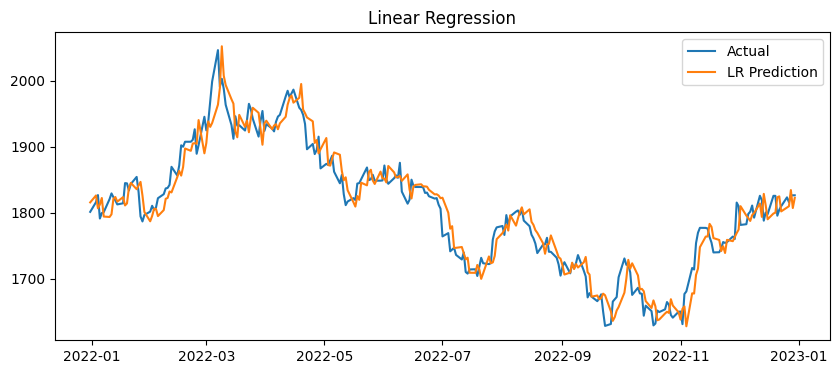

In [5]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression().fit(X_static, y_static)
lr_preds = []
history = train.copy()

for i in range(len(test)):
    X_curr = get_features(history)
    lr_preds.append(lr_model.predict(X_curr)[0])
    history = pd.concat([history, test.iloc[[i]]])

lr_res = get_metrics(test[target], lr_preds, "Linear Regression")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target], label='Actual')
plt.plot(test.index, lr_preds, label='LR Prediction')
plt.legend()
plt.title("Linear Regression")

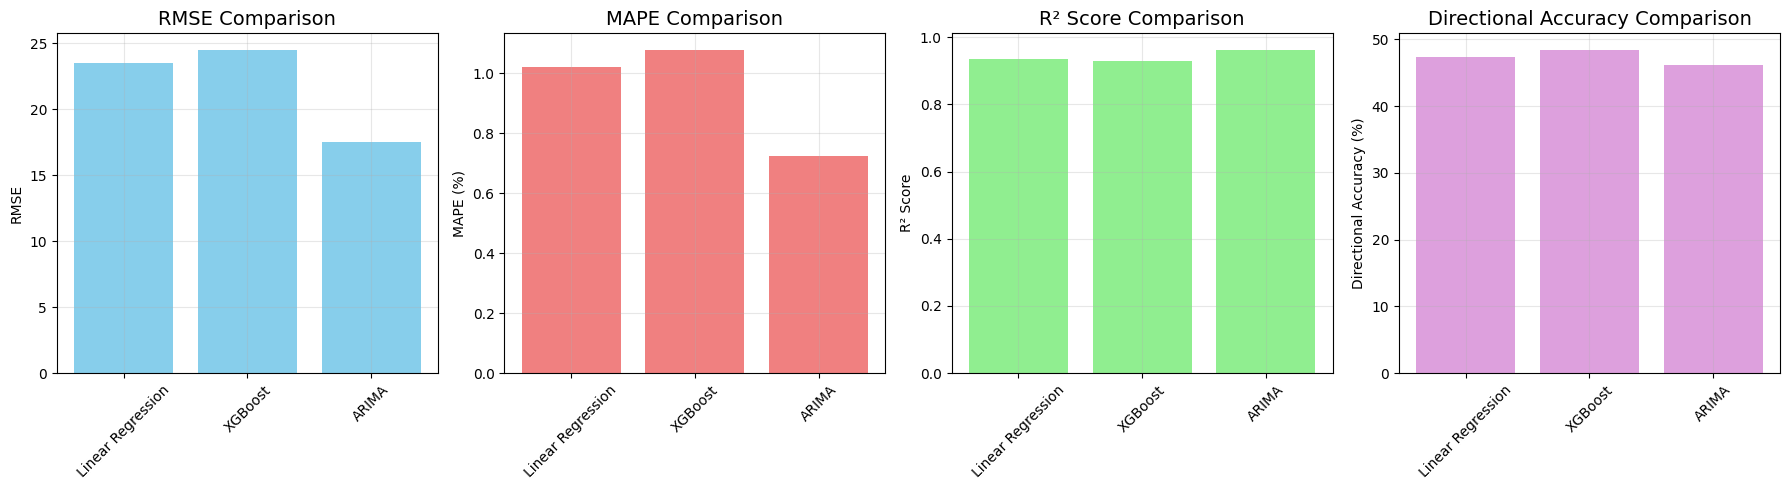

In [6]:
models = ['Linear Regression', 'XGBoost', 'ARIMA']
rmse_values = [lr_res[0], xgb_res[0], arima_res[0]]
mape_values = [lr_res[1], xgb_res[1], arima_res[1]]
r2_values = [lr_res[2], xgb_res[2], arima_res[2]]
da_values = [lr_res[3], xgb_res[3], arima_res[3]]

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

axes[0].bar(models, rmse_values, color='skyblue')
axes[0].set_title('RMSE Comparison', fontsize=14)
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

axes[1].bar(models, mape_values, color='lightcoral')
axes[1].set_title('MAPE Comparison', fontsize=14)
axes[1].set_ylabel('MAPE (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

axes[2].bar(models, r2_values, color='lightgreen')
axes[2].set_title('R² Score Comparison', fontsize=14)
axes[2].set_ylabel('R² Score')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

axes[3].bar(models, da_values, color='plum')
axes[3].set_title('Directional Accuracy Comparison', fontsize=14)
axes[3].set_ylabel('Directional Accuracy (%)')
axes[3].tick_params(axis='x', rotation=45)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()